In [1]:
# Setup plotting
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)


import pandas as pd
red_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

# Create training and validation splits
df_train = red_wine.sample(frac=0.7, random_state=0)
df_valid = red_wine.drop(df_train.index)

# Split features and target
X_train = df_train.drop('quality', axis=1).to_numpy()
X_valid = df_valid.drop('quality', axis=1).to_numpy()
y_train = df_train['quality'].to_numpy()
y_valid = df_valid['quality'].to_numpy()

In [2]:
import tensorflow as tf
tf.keras.backend.clear_session()

from tensorflow.keras import layers, models
import tensorflow.keras.backend as K

import tensorflow.experimental.numpy as tnp

class BatchNormFCLayer(tf.keras.layers.Layer):  # for the case of fully connected (1D inputs)
    """
    We create class variables such as gamma and beta to be trained. Also creating list of the accumulating
    tensors of moving_mean and moving_variance that are expected to grow up to window size. They are helpful for the
    last part of batchnorm algorithm where another affine transformation is performed using the averages
    """

    def __init__(self, epsilon=0.00000001, decay = 0.999):
        """
        :param epsilon:
        :param window:
        """
        super().__init__()

        gamma_init = tf.ones_initializer()
        self.gamma = tf.Variable(initial_value=gamma_init(shape=[1], dtype='float32'), trainable=True)
        
        beta_init = tf.zeros_initializer()
        self.beta = tf.Variable(initial_value=beta_init(shape=[1], dtype='float32'), trainable=True)
        
        self.decay = decay
        self.epsilon = epsilon

    def build(self, input_shape):  # should pass shape for your variable
        self.pop_mean = tf.Variable(tf.zeros([input_shape[-1]]), trainable=False)
        self.pop_var = tf.Variable(tf.ones([input_shape[-1]]), trainable=False)
        super().build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, training=False):  # Defines the computation from inputs to outputs
        mu = tf.math.reduce_mean(inputs, axis=0)
        variance = K.var(inputs, axis=0)

        if training:  # In case of training, perform batch normalization to learn beta and gamma
            #tf.print("Train",self.beta, self.gamma)
            self.pop_mean.assign( self.pop_mean * self.decay + mu * (1 - self.decay) )
            self.pop_var.assign( self.pop_var * self.decay + variance * (1 - self.decay) )

            #outputs = tf.nn.batch_normalization(inputs, mu, variance, self.beta, self.gamma, K.epsilon())
            x_hat = (inputs - mu)/tf.sqrt(tf.maximum(variance, K.epsilon()))
        
        else:  # In case of testing - calculation of the inference model
            #tf.print("Test",self.beta, self.gamma)
            #outputs = tf.nn.batch_normalization(inputs, self.pop_mean, self.pop_var, self.beta, self.gamma, K.epsilon())
            x_hat = (inputs - self.pop_mean)/tf.sqrt(tf.maximum(self.pop_var, K.epsilon()))
            
        outputs = self.gamma * x_hat + self.beta
        return outputs


In [3]:
from tensorflow import keras


model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[11]),
    layers.Dropout(0.3),
    BatchNormFCLayer(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1),
])

model.compile(
    optimizer='adam',
    loss='mae',
)

history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=10,
    validation_data=(X_valid, y_valid),
    verbose=0
)


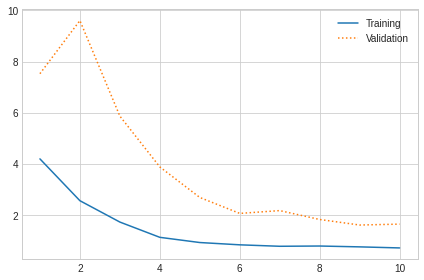

In [4]:
loss = history.history['loss']
val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, '-', label='Training')
plt.plot(epochs, val, ':', label='Validation')
plt.legend()

In [5]:
from sklearn.metrics import roc_auc_score

